# Zestaw 7. Iteracyjne rozwiązywanie układów równań liniowych

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import networkx as nx
from random import randint, random

## 1. Metody stacjonarne

<i>Zaimplementuj metody Jacobiego, Gaussa-Seidla i SOR. Użyj ich do rozwiązania poniższych układów równań z dokładnością do 4 miejsc znaczących.</i>

Przywołane metody iteracyjne mają szansę zadziałać tylko dla macierzy, której wszystkie elementy na przekątnej są niezerowe. Każdą macierz główną układu, który da się rozwiązać, jesteśmy w stanie doprowadzić do takiej postaci poprzez zamianę kolejności wierszy/kolumn.

Aby znaleźć kolejność wierszy, tak aby wszystkie liczby na przekątnej były niezerowe, wykorzystuję algorytm grafowy. Tworzę graf, łącząc wierzchołki oznaczające obecne numery wierszy z wierzchołkami oznaczającymi kolumny, tak że wiersz jest połączony z daną kolumną, jeśli wartość w tym wierszu i w tej kolumnie jest niezerowa. Poszukiwane rozwiązanie można utożsamić z pełnym skojarzeniem w tym grafie, jako iż każdy wiersz ma mieć przyporządkowaną dokładnie jedną kolumnę i żadne dwa wiersze nie mogą mieć przyporządkowanej tej samej kolumny.

Jako że zbudowany graf jest dwudzielny, możemy znaleźć w nim maksymalne skojarzenie w czasie wielomianowym, chociażby za pomocą metody Forda-Fulkersona. Skorzystałem z gotowej funkcji z biblioteki networkx.

In [2]:
def nonzero_diagonal(A, B):
    n = A.shape[0]
    
    graph = nx.Graph()
    
    for i in range(n):
        for j in range(n):
            if A[i, j] != 0:
                graph.add_edge(i, n+j)
    
    matching = nx.bipartite.maximum_matching(graph)
    new_A = np.zeros((n, n))
    new_B = np.zeros(n)
    
    for i, j in matching.items():
        if i > j: continue
        j -= n
        new_A[j] = A[i]
        new_B[j] = B[i]

    return new_A, new_B

Z twierdzenia o zbieżności procesu iteracyjnego, aby proces był zbieżny, promień spektralny macierzy iteracji musi być mniejszy od 1. Promień spektralny jest równy maksymalnej wartości bezwględnej z wartości własnych macierzy.

In [3]:
def spectral_radius(A):
    eigvals = np.linalg.eigvals(A)
    return abs(max(eigvals, key=abs))

W implementacji trzech metod iteracyjnych skorzystałem z operacji na macierzach. <br>

W przypadku dwóch ostatnich metod, do znalezienia macierzy odwrotnej wykorzystałem funkcję z modułu numpy. Z założenia, w metodach iteracyjnych dobieramy takie macierze, aby policzenie odwrotności było proste. Zdecydowałem się na użycie funkcji bibliotecznej, jednak sądzę, że nie zwiększy to błędu w szczególny sposób, gdyż przypuszczam, iż funkcja ta jest zoptymalizowana pod kątem szczególnych typów macierzy.

#### metoda Jacobiego

In [4]:
def jacobi(A, B, x0, exact, precision=1e-4):
    n = A.shape[0]
    
    A, B = nonzero_diagonal(A, B)
    
    x = x0
    D = np.diag(np.diag(A))
    inv_D = np.diag(1/np.diag(A))
    M = np.eye(n) - inv_D @ A   
    W = inv_D @ B
    
    radius = spectral_radius(M)
    if radius >= 1:
        raise Exception(f'spectral radius ({radius}) is not less than 1')
    
    errors = []
    i = 0
    
    while not np.allclose(x, exact, atol=precision):
        errors.append(np.mean((abs(exact-x))))
        x  = M @ x + W
        i += 1
    
    errors.append(np.mean((abs(exact-x))))
    return i, x, errors, radius

#### metoda Gaussa-Seidla

In [5]:
def gauss_seidl(A, B, x0, exact, precision=1e-4):
    n = A.shape[0]
    
    A, B = nonzero_diagonal(A, B)
    
    x = x0
    L = np.tril(A)
    
    U = np.triu(A) - np.diag(np.diag(A))
    M = -inv(L) @ U
    W = inv(L) @ B
    
    radius = spectral_radius(M)
    if radius >= 1:
        raise Exception(f'spectral radius ({radius}) is not less than 1')
    
    errors = []
    i = 0
    
    while not np.allclose(x, exact, atol=precision):
        errors.append(np.mean((abs(exact-x))))
        x  = M @ x + W
        i += 1
    
    errors.append(np.mean((abs(exact-x))))                  
    return i, x, errors, radius

#### metoda SOR

In [6]:
def sor(A, B, x0, exact, omega, precision=1e-4):
    n = A.shape[0]
    
    A, B = nonzero_diagonal(A, B)
    
    x = x0
    D = np.diag(np.diag(A))
    L = np.tril(A) - D
    U = np.triu(A) - D
    M = inv(D + omega*L) @ (D - omega*(D + U))
    W = omega * inv(D + omega*L) @ B
    
    radius = spectral_radius(M)
    if radius >= 1:
        raise Exception(f'spectral radius ({radius}) is not less than 1')
    
    i = 0
    errors = []
    
    while not np.allclose(x, exact, atol=precision):
        errors.append(np.mean((abs(exact-x))))
        x  = M @ x + W
        i += 1
    
    errors.append(np.mean((abs(exact-x))))   
    return i, x, errors, radius

#### testy

In [7]:
A1 = np.array([[7, 1, -1, 2], [1, 8, 0, -2], [-1, 0, 4, -1], [2, -2, -1, 6]])
B1 = np.array([3, -5, 4, -3])
x01 = np.zeros(4)
omega1 = 1.1
exact1 = np.array([1, -1, 1, -1])

In [8]:
A2 = np.array([[7, 3, -1, 2], [3, 8, 1, -4], [-1, 1, 4, -1], [2, -4, -1, 6]])
B2 = np.array([-1, 0, -3, 1])
x02 = np.zeros(4)
omega2 = 1.4
exact2 = np.array([-1, 1, -1, 1])

In [9]:
def test_solve(A, B, x0, exact, omega):
    jacobi_res = jacobi(A, B, x0, exact)
    gauss_seidl_res = gauss_seidl(A, B, x0, exact)
    sor_res = sor(A, B, x0, exact, omega)
    
    print(f"\n--JACOBI--\n\titerations: {jacobi_res[0]} | result: {jacobi_res[1]}")
    print('\tspectral radius:', jacobi_res[3])
    
    print(f"--GAUSS-SEIDL--\n\titerations: {gauss_seidl_res[0]} | result: {gauss_seidl_res[1]}")
    print('\tspectral radius:', gauss_seidl_res[3])
    
    print(f"--SOR--\n\titerations: {sor_res[0]} | result: {sor_res[1]}")
    print('\tspectral radius:', sor_res[3])

In [10]:
test_solve(A1, B1, x01, exact1, omega1)


--JACOBI--
	iterations: 14 | result: [ 0.99995716 -0.99995716  1.00000235 -0.99992703]
	spectral radius: 0.4966500211811145
--GAUSS-SEIDL--
	iterations: 7 | result: [ 0.99989203 -0.99991255  1.00004696 -0.99992703]
	spectral radius: 0.24666124353920096
--SOR--
	iterations: 5 | result: [ 1.00002942 -1.00002682  0.99996387 -1.00000953]
	spectral radius: 0.10000000000000009


In [11]:
test_solve(A2, B2, x02, exact2, omega2)


--JACOBI--
	iterations: 71 | result: [-0.99991675  0.99990401 -0.99997751  0.99989967]
	spectral radius: 0.8770907658496181
--GAUSS-SEIDL--
	iterations: 36 | result: [-0.99990588  0.99990014 -0.99998236  0.999905  ]
	spectral radius: 0.7698961627782164
--SOR--
	iterations: 11 | result: [-1.00007883  1.00007612 -0.99995452  1.00006055]
	spectral radius: 0.41711260752444557


#### zależność błędu od liczby iteracji

<i>Zaprezentuj na wykresie zależność błędu od iteracji. Opisz i zinterpretuj wyniki. </i>

In [12]:
def plot_iteration_error(A, B, x0, exact, omega):
    jacobi_errors = jacobi(A, B, x0, exact)[2]
    gauss_seidl_errors = gauss_seidl(A, B, x0, exact)[2]
    sor_errors = sor(A, B, x0, exact, omega)[2]
    
    _, ax = plt.subplots(figsize=(10,6))
    
    ax.set_xlabel('iteration')
    ax.set_ylabel('error')
    
    ax.plot(list(range(len(jacobi_errors))), jacobi_errors, marker='o', label='jacobi', color='rosybrown', markersize=8)
    ax.plot(list(range(len(gauss_seidl_errors))), gauss_seidl_errors, marker='o', label='gauss-seidl', color='lightskyblue', markersize=8)
    ax.plot(list(range(len(sor_errors))), sor_errors, marker='o', label='sor', color='mediumaquamarine', markersize=8)
    
    plt.legend()
    plt.show()

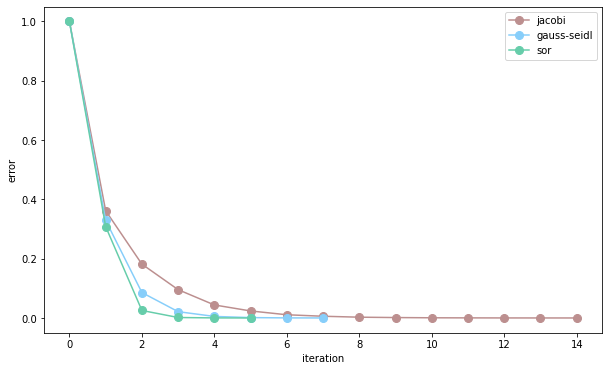

In [13]:
plot_iteration_error(A1, B1, x01, exact1, omega1)

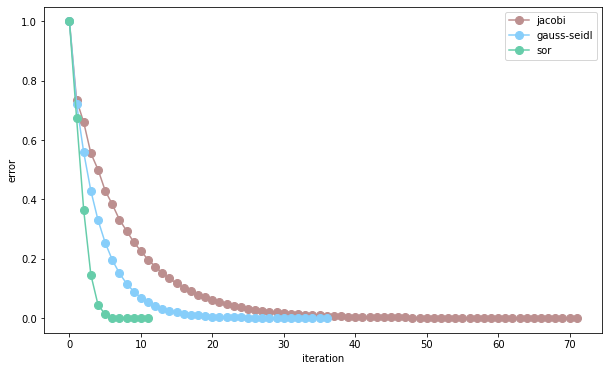

In [14]:
plot_iteration_error(A2, B2, x02, exact2, omega2)

Dla obydwu przykładowych układów wszystkie metody poprawnie odnalazły rozwiązanie z zadaną dokładnością. Najszybciej zbiegająca okazała się metoda SOR, nieco wolniejsza była metoda Gaussa-Seidla, a najwolniej zbiegała metoda Jacobiego. Skuteczność metody SOR wynika jednak z doboru omegi, która była podana. Przyjmując omega=1 metoda SOR jest równoważna metodzie Gaussa-Seidla, jednak dobierając korzystną wartość omegi, jesteśmy w stanie przyspieszyć procedurę.

Wyraźnie widać, iż wyniki otrzymane dla drugiej macierzy są gorsze niż te dla pierwszej; wszystkie metody potrzebowały większej liczby iteracji do osiagnięcia zamierzonej dokładności. Wynika to z parametrów zadanej macierzy oraz wybranej macierzy iteracji, a konkretnie jej promienia spektralnego. 

Można zauważyć, że im mniejsza wartość promienia spektralnego, tym szybciej metoda zbiega do poprawnej wartości. We wszystkich przypadkach promień spektralny był mniejszy od 1, co pozwoliło uzyskać poprawny wynik, jednak konkretna wartość różniła się, co bezpośrednio wpłynęło na liczbę potrzebnych iteracji.

## 2. Analiza obwodu elektrycznego

<i> Wykorzystaj dowolną z powyższych metod do wyliczenia natężenia prądu w każdej z części obwodu elektrycznego. <br><br>
a) Stwórz funkcję tworzącą graf opisujący obwód elektryczny. Argumentami tej funkcji są:

* Lista krawędzi grafu ważonego gdzie wagi krawędzi określają opór fragmentu obwodu między dwoma węzłami. Wierzchołki grafu identyfikowane są przez liczby naturalne.
* Trójka liczb (s, t, E), przy czym para (s, t) wskazuje między którymi węzłami sieci przyłożono siłę elektromotoryczną E. Opór wewnętrzny SEM można zaniedbać. </i>

In [15]:
def create_graph(resistors, emf):
    graph = nx.DiGraph()
    
    for a, b, resistance in resistors:
        graph.add_edge(a, b, weight=resistance)
        
    s, t, _ = emf
    if (s, t) not in graph.edges() and (t, s) not in graph.edges():
        graph.add_edge(s, t, weight=0)
    
    return graph

In [16]:
def draw_graph(graph, pos):
    plt.figure(figsize=(10, 5))
    nx.draw_networkx(graph, pos, with_labels=True, node_color='lawngreen')
    labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=labels)

<i>b) Napisz funkcję, która wykorzystując prawa Kirchhoffa znajdzie natężenia prądu w każdej części obwodu i przedstawi je na rysunku w postaci grafu ważonego z etykietami. </i>

In [17]:
def get_amperage(graph, s, t, voltage):
    n = graph.number_of_edges()
    A = np.zeros((n, n))
    B = np.zeros(n)

    edges = {x: i for i, x in enumerate(graph.edges())}
    
    row = 0
    
    # Drugie Prawo Kirchhoffa
    for cycle in nx.cycle_basis(graph.to_undirected()):
        for j in range(len(cycle)):
            v1, v2 = cycle[j-1], cycle[j]
            
            # opór elektryczny
            if (v1, v2) in edges:
                A[row][edges[v1, v2]] = graph[v1][v2]['weight']
            else:
                A[row][edges[v2, v1]] = -graph[v2][v1]['weight']
                
            # siła elektromotoryczna ogniwa
            if (v1, v2) == (s, t):
                B[row] = voltage
            elif (v1, v2) == (t, s):
                B[row] = -voltage
                
        row += 1
        
    # Pierwsze Prawo Kirchhoffa
    for v1 in graph.nodes():
        if row >= n: break
            
        for v2 in graph[v1]:
            A[row][edges[v1, v2]] = 1
        for v2, _ in graph.in_edges(v1):
            A[row][edges[v2, v1]] = -1
        
        row += 1
    

    exact = np.linalg.solve(A, B)
    
    try:
        x = gauss_seidl(A, B, np.zeros(len(edges)), exact, precision=0.5)
    except Exception as ex:
        print(ex)
        x = exact
    
    solution_graph = nx.DiGraph()
    
    for edge, i in edges.items():
        a, b = (edge[0], edge[1]) if x[i] > 0 else (edge[1], edge[0])
        solution_graph.add_edge(a, b, weight=round(abs(x[i]), 2))
    
    return solution_graph

<i>c) Przetestuj działanie metody dla obwodu przedstawionego na Rysunku 1, wiedząc, że poprawne rozwiązanie to $x_1 = 26.5, x_2 = 9.35, x_3 = 13.3, x_4 = 6.13$ </i>

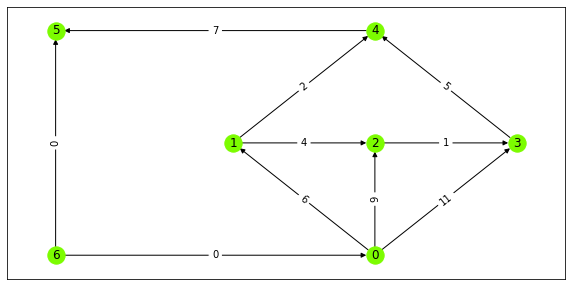

In [18]:
resistors = [(0, 1, 6), (0, 2, 9), (0, 3, 11), (1, 2, 4), (1, 4, 2), (2, 3, 1), (3, 4, 5), (4, 5, 7), (6, 0, 0)]
emf = (6, 5, 300)

pos = {0: (10, 1), 1: (6, 5), 2: (10, 5), 3: (14, 5), 4: (10, 9), 5: (1, 9), 6:(1, 1)}

graph = create_graph(resistors, emf)
draw_graph(graph, pos)

spectral radius (1.8606559825732945) is not less than 1


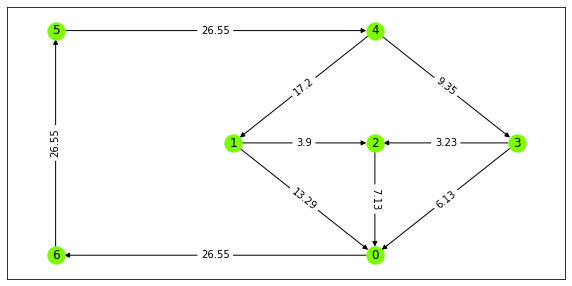

In [19]:
result_graph = get_amperage(graph, *emf)
draw_graph(result_graph, pos)

Powyższy rysunek przedstawia rozwiązanie problemu. Liczby na krawędziach oznaczają wartość natężenia prądu w danej części obwodu, w jednostce odpowiadającej podanym jednostkom napięcia i oporu. Zwrot krawędzi prezentuje kierunek prądu.

Nie korzystałem z podanego w treści wyniku, bo nie zostały podane wszystkie wartości natężenia. Zamiast tego użyłem procedury np.linalg.solve, której rezultat przyjąłem za poprawny wynik i do niego dążyłem w metodach iteracyjnych.

W tym przypadku, macierz iteracji miała promień spektralny niemniejszy od 1, co uniemożliwiło użycie tej metody do znalezienia rozwiązania, wobec tego wykorzystałem wynik funkcji bibliotecznej.

<i>d) Przedstaw (wizualizacja oraz sprawdzenie poprawności wyników) działanie programu dla grafów spójnych mających od 15 do 100 wierzchołków. </i>
    

In [20]:
def check_solution(graph, solution, s, t, voltage):
    n = graph.number_of_edges()
    graph = graph.to_undirected()
    edges = {x: i for i, x in enumerate(solution.edges())}

    for cycle in nx.cycle_basis(graph):
        voltage_sum = 0
        for j in range(len(cycle)):
            v1, v2 = cycle[j-1], cycle[j]
            
            if (v1, v2) in edges:
                voltage_sum -= solution[v1][v2]['weight']*graph[v1][v2]['weight']
            else:
                voltage_sum += solution[v2][v1]['weight']*graph[v1][v2]['weight']
                
            if (v1, v2) == (s, t):
                voltage_sum += voltage
            elif (v1, v2) == (t, s):
                voltage_sum -= voltage
                        
        if abs(voltage_sum) > 0.2:
            return False
    
    for v1 in solution.nodes():
        amperage_sum = 0
        for v2 in solution[v1]:
            amperage_sum += solution[v1][v2]['weight']
        for v2, _ in solution.in_edges(v1):
            amperage_sum -= solution[v2][v1]['weight']
        
        if abs(amperage_sum) > 0.2:
            return False
            
    return True

In [21]:
def solve_and_test(graph, s, t, voltage, pos):
    solution = get_amperage(graph, s, t, voltage)
    draw_graph(solution, pos)
    print('correct?', check_solution(graph, solution, s, t, voltage))

* Spójny graf losowy

In [22]:
def get_random_graph(n):
    edges = []
    for i in range(n-1):
        connected = randint(i+1, n-1) if i != 0 else n-1
        edges.append((i, connected, randint(1, 10)))
        
        for j in range(i+1, n):
            if i != j and j != connected and random() < 0.2:
                edges.append((i, j, randint(1, 10)))
    
    
    s = randint(0, n-2)
    t = randint(s+1, n-1)
    emf = (s, t, randint(100, 500))
    
    return create_graph(edges, emf), emf

> |V| = 15

In [23]:
while True:
    random_graph, emf = get_random_graph(15)
    if nx.is_connected(random_graph.to_undirected()):
        break

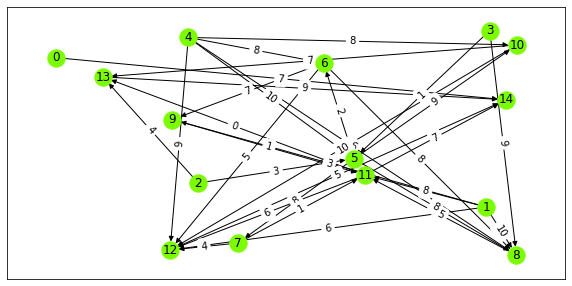

In [24]:
random_pos = nx.random_layout(random_graph)
draw_graph(random_graph, random_pos)

spectral radius (4.9468015532096805) is not less than 1
correct? True


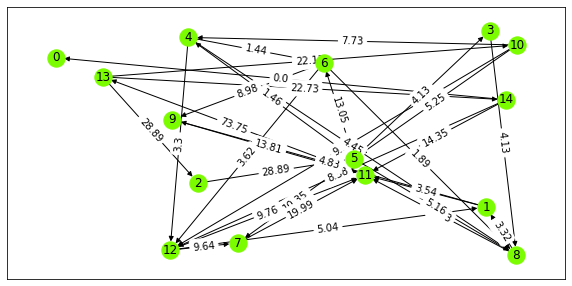

In [25]:
solve_and_test(random_graph, *emf, random_pos)

> |V| = 100

In [26]:
while True:
    random_graph, emf = get_random_graph(100)
    if nx.is_connected(random_graph.to_undirected()):
        break

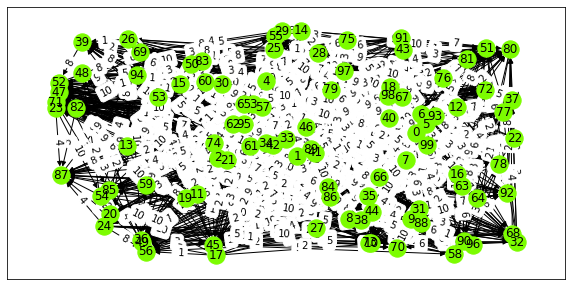

In [27]:
random_pos = nx.random_layout(random_graph)
draw_graph(random_graph, random_pos)

spectral radius (241.81819533607077) is not less than 1
correct? True


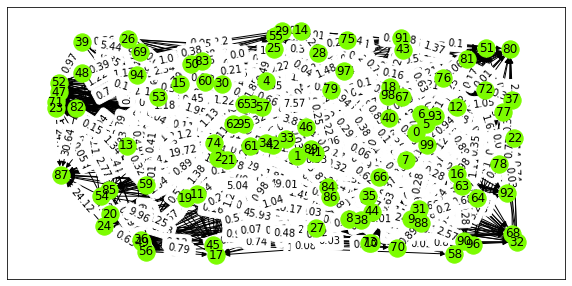

In [28]:
solve_and_test(random_graph, *emf, random_pos)

* Graf 3-regularny (kubiczny)

In [29]:
def get_cubical_graph():
    edges = []
    for i, j in nx.generators.small.cubical_graph().edges():
        edges.append((i, j, randint(1, 10)))
    emf = (edges[0][0], edges[0][1], 300)
    return create_graph(edges, emf), emf

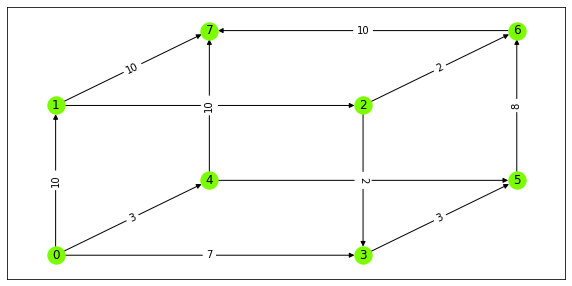

In [30]:
cubical_graph, emf = get_cubical_graph()
cubical_pos = {0: (0,0), 1: (0,2), 2: (2,2), 3:(2,0), 4:(1, 1), 5:(3,1), 6:(3,3), 7:(1,3)}
draw_graph(cubical_graph, cubical_pos)

spectral radius (14.282759226573878) is not less than 1
correct? True


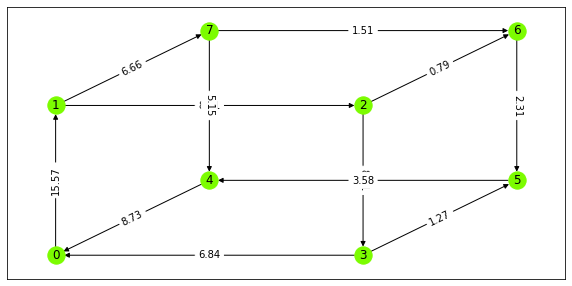

In [31]:
solve_and_test(cubical_graph, *emf, cubical_pos)

* Graf złożony z dwóch grafów losowych połączonych mostkiem

In [32]:
def get_bridge_graph(n):
    edges = []
    for i in range(n-1):
        connected = randint(i+1, n-1) if i != 0 else n-1
        edges.append((i, connected, randint(1, 10)))
        
        for j in range(i+1, n):
            if i != j and j != connected and random() < 0.2:
                edges.append((i, j, randint(1, 10)))
                
    for i in range(n, 2*n-1):
        connected = randint(i+1, 2*n-1) if i != n else 2*n-1
        edges.append((i, connected, randint(1, 10)))
        
        for j in range(i+1, 2*n):
            if i != j and j != connected and random() < 0.2:
                edges.append((i, j, randint(1, 10)))
                
    emf = (0, n, randint(100, 300))
    return create_graph(edges, emf), emf

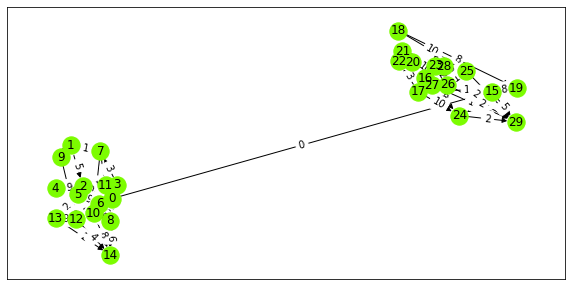

In [33]:
n = 15
bridge_graph, emf = get_bridge_graph(15)
bridge_pos = nx.spring_layout(bridge_graph)
draw_graph(bridge_graph, bridge_pos)

spectral radius (19.137781897248946) is not less than 1
correct? True


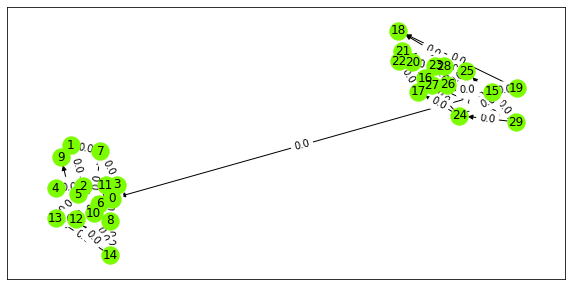

In [34]:
solve_and_test(bridge_graph, *emf, bridge_pos)

* Graf siatka 2D

In [35]:
def get_grid_graph(n, k):
    edges = []
    for i, j in nx.generators.lattice.grid_2d_graph(n, k).edges():
        edges.append((i, j, randint(1, 10)))
        
    emf = (edges[0][0], edges[0][1], 300)
    return create_graph(edges, emf), emf

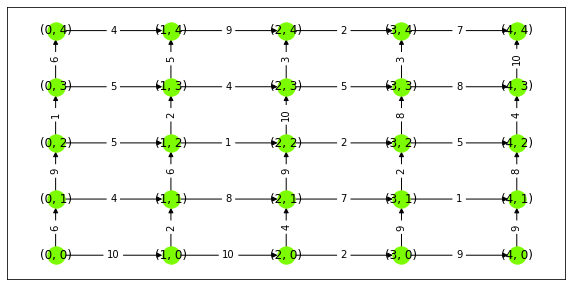

In [38]:
n, k = (5, 5)
grid_graph, emf = get_grid_graph(n, k)
grid_pos = pos = {(i, j): (i, j) for i in range(n) for j in range(k)}
draw_graph(grid_graph, grid_pos)

spectral radius (9.979727267011404) is not less than 1
correct? True


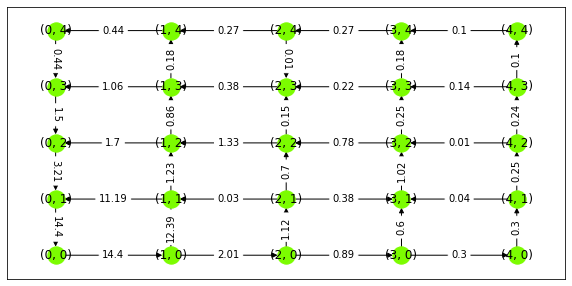

In [39]:
solve_and_test(grid_graph, *emf, grid_pos)

Zaimplementowane procedury pozwoliły znaleźć wartości natężenia prądu w każdej części układu. W większości przypadków macierz iteracji miała zbyt duży promień spektralny, aby można było użyć metody iteracyjnej i zamiast niej wynik uzyskany został w sposób bezpośredni. Może to wynikać z tego, iż macierze główne powyższych układów raczej nie są diagonalnie dominujące, symetryczne ani dodatnio określone.

## Wnioski

 - Rozwiązywanie układów równań liniowych jest częstym krokiem wielu algorytmów wykorzystywanych w różnych dziedzinach nauki. Metody iteracyjne stanowią alternatywne podejście do poznanych algorytmów bezpośrednich.
 - Powodzenie iteracyjnej procedury znajdowania rozwiązania zależy od wyboru metody, wynikającej z niej macierzy iteracji i specyfiki macierzy układu. Metody iteracyjne nie sprawdzają się w każdym przypadku.

M. Hawryluk 05.05.2021